In [119]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.signal import fftconvolve

In [120]:
# ---------------------------------------------------------
# 0. Classical initial probability distributions
# ---------------------------------------------------------

def exponential_P(x, lam=1.0):
    """Exponential distribution on [0,∞)."""
    return lam * np.exp(-lam * x)

def gamma_P(x, k=2, theta=1.0):
    """Gamma distribution."""
    from scipy.stats import gamma
    return gamma.pdf(x, a=k, scale=theta)

def gaussian_cut_P(x, mu=1.0, sigma=0.5):
    """Gaussian truncated to [0,∞)."""
    P = np.exp(-(x-mu)**2/(2*sigma**2))
    return np.where(x >= 0, P, 0)

def fermi_dirac_P(x, mu=1.0, T=0.2):
    """Finite-temperature Fermi-Dirac distribution on [0,∞) (numerically normalized)."""
    # Avoid overflow in exp((x - mu)/T)
    arg = (x - mu) / T
    P = 1.0 / (np.exp(arg) + 1.0)
    
    # Make sure it's zero for negative energies (if x-grid includes them)
    P = np.where(x >= 0, P, 0)
    
    # Normalize numerically
    norm = np.trapezoid(P, x)
    if norm > 0:
        P /= norm
    
    return P

In [121]:
# ---------------------------------------------------------
# 2. define evolution step
# ---------------------------------------------------------

def shift_left(P, dx, dGamma):
    from scipy.interpolate import interp1d
    x = np.arange(len(P)) * dx
    f = interp1d(x - dGamma, P, bounds_error=False, fill_value=0)
    return f(x)

def evolve(P, x, dGamma):
    dx = x[1] - x[0]
    N = len(x)

    # -----------------------------
    # Exact left shift by dGamma
    # -----------------------------
    # shift_idx = int(dGamma / dx)
    # P_shift = np.zeros_like(P)
    # if shift_idx < N:
    #     P_shift[:-shift_idx] = P[shift_idx:]

    P_shift = shift_left(P, dx, dGamma)

    # -----------------------------
    # Correct "delta" convolution
    #  -----------------------------
    # P_conv = np.zeros_like(P)
    # for i in range(N):
    #     j_max = i + 1
    #     if j_max > 0:
    #         P_r = P[i - np.arange(j_max)]
    #         P_l = P[:j_max]
    #         P_conv[i] = np.sum(P_l * P_r) * dx

    P_conv = fftconvolve(P, P)[:N] * dx

    # # Normalize P_conv
    # integral_conv = np.trapezoid(P_conv, x)
    # if integral_conv > 0:
    #     P_conv /= integral_conv

    #print("Integral of P_conv(x):", np.trapezoid(P_conv, x))

    # -----------------------------
    # Integral of P from 0 to dGamma
    # -----------------------------
    mask = x <= dGamma
    A0 = np.trapezoid(P[mask], x[mask])
    #print("A0:",A0)

    # -----------------------------
    # Updated pdf
    # -----------------------------
    P_new = P_shift + A0 * P_conv
    P_new = np.maximum(P_new, 0)

    #print("renormalization of P_new without renormalizing", np.trapezoid(P_new, x))

    P_new /= np.trapezoid(P_new, x)

    return P_new

In [134]:
# # Convert current p_zeta to p_J

# def zeta_to_J_pdf(pZ, zeta_grid, Omega):
#     J_vals = Omega * np.exp(-zeta_grid)
#     # p_J(J) = p_Z(ζ(J)) * 1/J
#     pJ = pZ / J_vals
#     # Interpolate onto a uniform J grid (optional)
#     return J_vals, pJ / np.trapezoid(pJ, J_vals)

def zeta_to_J_pdf_stable(pZ, zeta_grid, Omega, N_J=2000, J_min=1e-10):
    # Create ascending log J grid
    J_max = Omega
    J_vals = np.linspace(J_min, J_max, N_J)

    print(J_vals)

    # Corresponding zeta values
    zeta_for_J = np.log(Omega / J_vals)

    # Interpolate pZ onto zeta_for_J
    pZ_interp = np.interp(zeta_for_J, zeta_grid, pZ, left=0, right=0)

    # Apply Jacobian
    pJ = pZ_interp / J_vals

    # Normalize
    pJ /= np.trapz(pJ, J_vals)

    return J_vals, pJ



# Convert current p_J to p_zeta

def J_to_zeta_pdf(pJ, J_grid, Omega):
    zeta_vals =np.log(Omega/J_grid)
    # p_\zeta(\zeta) = p_J(J(\zeta)) * \zeta * \Omega*exp(-\zeta)
    pZ = pJ * J_grid 
    # Interpolate onto a uniform J grid (optional)
    return zeta_vals, pZ / np.trapezoid(pZ, zeta_vals)



In [123]:
# ---------------------------------------------------------
# Set up J-grid, ζ-grid and boundaries
# ---------------------------------------------------------

def intelligent_xmax(x, P, p=0.99):
    dx = x[1] - x[0]
    cdf = np.cumsum(P) * dx
    cdf = np.clip(cdf, 0, 1)
    return np.interp(p, cdf, x)

Omega0 = 10.0                     # initial energy scale
N_J = 2000
J = np.linspace(1e-10, Omega0, N_J)   # avoid 0

zeta_max = np.log(Omega0/J[0])*10                # choose a value that takes into account how far the tail of final distribution goes
N = 50000 + 1                        # +1 to get a round dx
zeta = np.linspace(0, zeta_max, N)
dzeta = zeta[1] - zeta[0]

dGamma = 0.1

# ratio = dGamma/dzeta
# if (ratio < 10) or (not ratio.is_integer()):
#     print("dGamma",dGamma,"must be >> dzeta", dzeta,"and the ratio must be an integer!" )

# ---------------------------------------------------------
# Initial PDFs in J space (they must be normalized)
# ---------------------------------------------------------

initial_distributions_J = {
    "Gamma(k=2,θ=1)": lambda J: gamma_P(J, k=2, theta=1.0),
    "Gaussian cut (μ=1,σ=0.5)": lambda J: gaussian_cut_P(J, mu=1.0, sigma=0.5),
    "Exponential (λ=1)": lambda J: exponential_P(J, lam=1.0),
    "Fermi-Dirac (μ=1,T=0.1)": lambda J: fermi_dirac_P(J, mu=1.0, T=0.1)
}

# ---------------------------------------------------------
# Convert initial PDFs from J to ζ
# ---------------------------------------------------------

initial_distributions_zeta = {}

for name, pdf_J in initial_distributions_J.items():

    # Evaluate p_J on the J grid
    pJ = pdf_J(J)
    # normalize pJ(J)
    pJ /= np.trapezoid(pJ, J)

    # Convert J -> ζ
    # J(ζ) = Ω e^{-ζ}
    J_of_zeta = Omega0 * np.exp(-zeta)

    # p_ζ(ζ) = p_J(J(ζ)) * |dJ/dζ| = p_J(J(ζ)) * J(ζ)
    pJ_interp = np.interp(J_of_zeta, J, pJ, left=0, right=0)
    pZ = pJ_interp * J_of_zeta

    # Normalize on ζ grid
    pZ /= np.trapezoid(pZ, zeta)

    # Store
    initial_distributions_zeta[name] = pZ

# plt.figure(figsize=(12,6))
# plt.plot(J_of_zeta)
# plt.show()



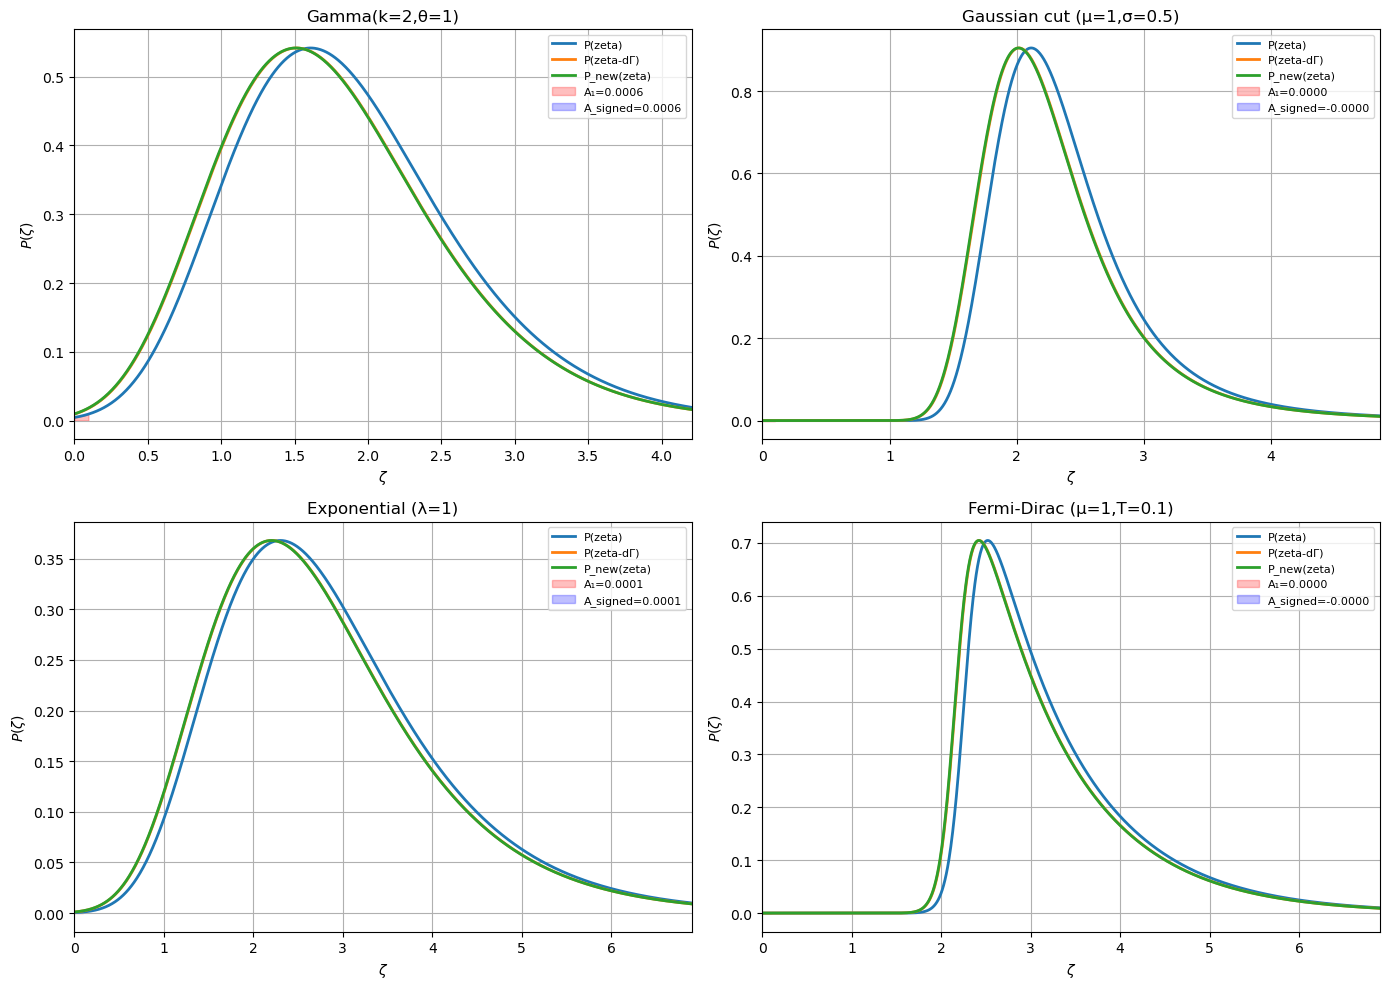

In [124]:
# ============================================
# Plot all initial distributions in ζ-space
# ============================================

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for ax, (name, P_orig) in zip(axes, initial_distributions_zeta.items()):
    # Copy array to avoid modifying original
    P = P_orig.copy()
    
    # Ensure normalization
    P /= np.trapezoid(P, zeta)

    # Evolve once
    P_new = evolve(P, zeta, dGamma)

    # Build shifted P(zeta - dGamma)
    P_shift = np.zeros_like(P)
    shift_idx = int(dGamma / dzeta)
    if shift_idx < len(P):
        P_shift[:-shift_idx] = P[shift_idx:]
    else:
        # If shift is larger than array, leave P_shift as zeros
        shift_idx = len(P) - 1

    # Compute intelligent zeta-limit for plotting
    zeta_max_plot = intelligent_xmax(zeta, P, p=0.99)

    # ------------------------------
    # Plot curves
    # ------------------------------
    ax.plot(zeta, P, label="P(zeta)", linewidth=2)
    ax.plot(zeta, P_shift, label=f"P(zeta-dΓ)", linewidth=2)
    ax.plot(zeta, P_new, label="P_new(zeta)", linewidth=2)

    # ------------------------------
    # Region 1: area under P(zeta) in [0, dGamma]
    # ------------------------------
    mask_region1 = (zeta >= 0) & (zeta <= dGamma)
    area1 = np.trapezoid(P[mask_region1], zeta[mask_region1])
    ax.fill_between(
        zeta[mask_region1], P[mask_region1],
        color="red", alpha=0.25,
        label=f"A₁={area1:.4f}"
    )

    # ------------------------------
    # Region 2: signed difference P_new - P_shift
    # ------------------------------
    diff = P_new - P_shift
    area_signed = np.trapezoid(diff, zeta)

    mask_pos = diff > 0
    mask_neg = diff < 0

    ax.fill_between(
        zeta, P_shift, P_new,
        where=mask_pos,
        color="blue", alpha=0.25,
        label=f"A_signed={area_signed:.4f}"
    )
    ax.fill_between(
        zeta, P_shift, P_new,
        where=mask_neg,
        color="blue", alpha=0.25
    )

    # ------------------------------
    # Formatting
    # ------------------------------
    ax.set_xlim(0, zeta_max_plot)
    ax.set_xlabel(r"$\zeta$")
    ax.set_ylabel(r"$P(\zeta)$")
    ax.set_title(name)
    ax.grid(True)
    ax.legend(fontsize=8)

plt.tight_layout()
plt.show()


In [125]:
def mean_P(x, P):
    return np.trapezoid(x * P, x)

def sigma_P(x, P):
    m = mean_P(x, P)
    return np.sqrt(np.trapezoid((x - m)**2 * P, x))

def exponential_pdf(x, Gamma):
    return np.exp(-x / Gamma) / Gamma

def L1_distance(P, P_ref, x):
    return np.trapezoid(np.abs(P - P_ref), x)


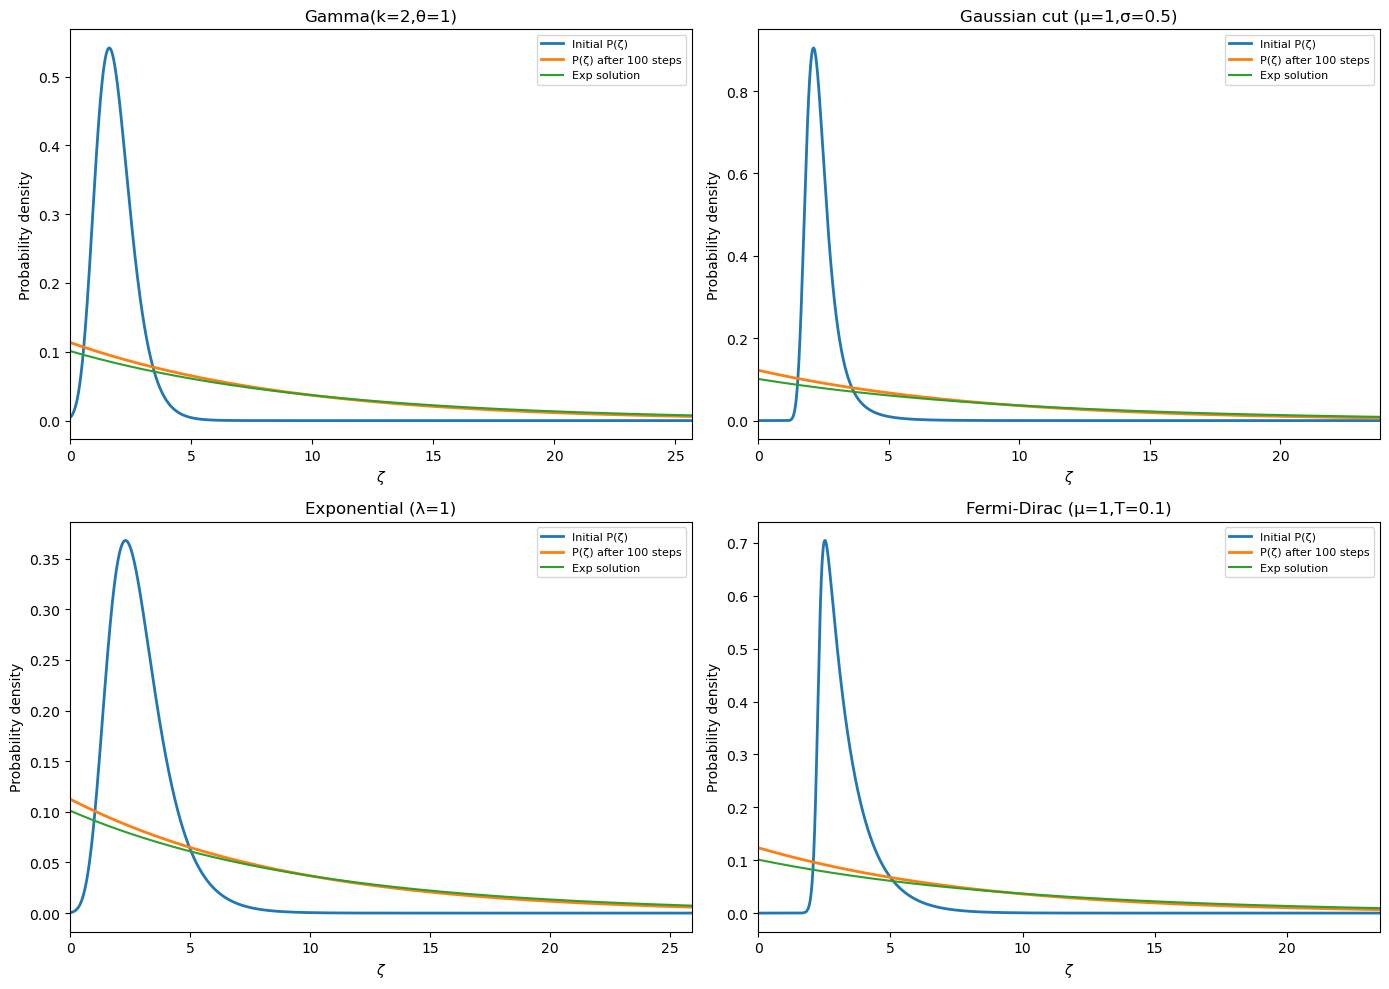

In [157]:
# ============================================
#  Evolution for all 4 initial distributions
# ============================================

n_steps = 100  # number of RG steps

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

# To store diagnostics for all distributions
results = {}

for ax, (name, P_init_orig) in zip(axes, initial_distributions_zeta.items()):
    
    # ---------------------------------------------------------
    # Build initial distribution (copy to avoid modifying original)
    # ---------------------------------------------------------
    P_init = P_init_orig.copy()
    P_init /= np.trapezoid(P_init, zeta)  # normalize on zeta grid

    # ---------------------------------------------------------
    # Initialize storage lists
    # ---------------------------------------------------------
    Gammas = []
    Means = []
    Sigmas = []
    Errors = []

    # ---------------------------------------------------------
    # Evolve for n_steps
    # ---------------------------------------------------------
    P_current = P_init.copy()
    for step in range(n_steps):

        Gamma = (step) * dGamma
        Gammas.append(Gamma)

        # diagnostics BEFORE evolution step
        m = mean_P(zeta, P_current)
        s = sigma_P(zeta, P_current)
        Means.append(m)
        Sigmas.append(s)

        # exponential reference PDF
        P_ref = exponential_pdf(zeta, Gamma if Gamma > 0 else dGamma)
        err = L1_distance(P_current, P_ref, zeta)
        Errors.append(err)

        # evolve one RG step
        P_current = evolve(P_current, zeta, dGamma)

    # save diagnostics
    results[name] = {
        "Gamma": np.array(Gammas),
        "Mean": np.array(Means),
        "Sigma": np.array(Sigmas),
        "Error": np.array(Errors)
    }

    # ---------------------------------------------------------
    # Intelligent plot cutoff (based on final PDF)
    # ---------------------------------------------------------
    zeta_max_plot = intelligent_xmax(zeta, P_current, p=0.95)

    # ---------------------------------------------------------
    # Plot
    # ---------------------------------------------------------
    ax.plot(zeta, P_init, label="Initial P(ζ)", linewidth=2)
    ax.plot(zeta, P_current, label=f"P(ζ) after {n_steps} steps", linewidth=2)
    ax.plot(zeta, exponential_pdf(zeta, Gamma), label="Exp solution")

    ax.set_xlim(0, zeta_max_plot)
    ax.set_title(name)
    ax.set_xlabel(r"$\zeta$")
    ax.set_ylabel("Probability density")
    ax.legend(fontsize=8)

plt.tight_layout()
plt.show()


9.99999999999998
[1.00000000e-10 1.32973381e-07 2.65846762e-07 ... 2.65348242e-04
 2.65481115e-04 2.65613989e-04]
[1.00000000e-10 1.32973381e-07 2.65846762e-07 ... 2.65348242e-04
 2.65481115e-04 2.65613989e-04]
[1.00000000e-10 1.32973381e-07 2.65846762e-07 ... 2.65348242e-04
 2.65481115e-04 2.65613989e-04]
min J: 1e-10 max J: 0.00026561398887587435
min pJ: 29.144472670093194 max pJ: 14425183.859795563
Integral: 1.0


/var/folders/5k/s52gh14n4t75_lrp5kzh2bnc0000gn/T/ipykernel_11162/3113112347.py:27: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  pJ /= np.trapz(pJ, J_vals)
/var/folders/5k/s52gh14n4t75_lrp5kzh2bnc0000gn/T/ipykernel_11162/2002423205.py:41: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  print("Integral:", np.trapz(pJ_recovered, J_vals))


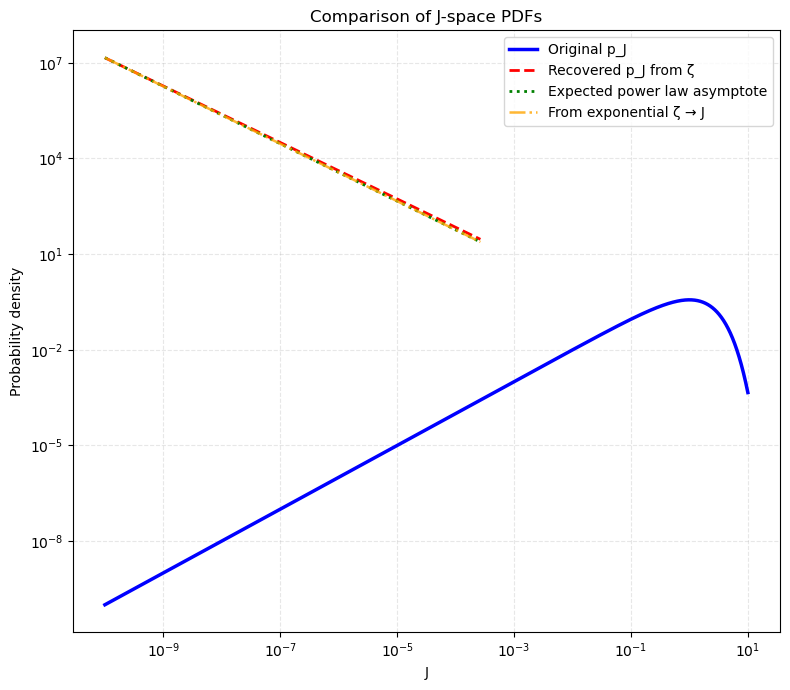

L1 difference between original and recovered p_J: 36371.37197827041


In [195]:
import matplotlib.pyplot as plt

def real_power_law(x, Omega, Gamma):
    px = 1/(Omega*Gamma)* ((Omega/x)** (1-1/Gamma))
    return px / np.trapezoid(px, x)

# Pick the Gamma PDF
name = "Gamma(k=2,θ=1)"

# Original PDF in J-space
pJ_orig = initial_distributions_J[name](J)
pJ_orig /= np.trapezoid(pJ_orig, J)  # normalize

# Converted to ζ-space
pZ = initial_distributions_zeta[name]

# print(pZ)
Omega0 = 10


Omega = Omega0
Gamma = 0

for i in range(100):
    pZ = evolve(pZ, zeta, dGamma)
    Omega = Omega - Omega * dGamma
    Gamma = Gamma + dGamma

print(Gamma)


# Convert to J-space using stable function
J_vals, pJ_recovered = zeta_to_J_pdf_stable(pZ, zeta, Omega, N_J=2000)

J_vals, pJ = zeta_to_J_pdf_stable(P_current, zeta, Omega)

J_vals, pJ_exp = zeta_to_J_pdf_stable(exponential_pdf(zeta, Gamma), zeta, Omega)

print("min J:", J_vals[0], "max J:", J_vals[-1])
print("min pJ:", pJ_recovered.min(), "max pJ:", pJ_recovered.max())
print("Integral:", np.trapz(pJ_recovered, J_vals))

plt.figure(figsize=(8,7))

plt.plot(J, pJ_orig,
         label="Original p_J",
         linewidth=2.5,
         color="blue")

plt.plot(J_vals, pJ_recovered,
         label="Recovered p_J from ζ",
         linewidth=2,
         linestyle="--",
         color="red")

plt.plot(J_vals, real_power_law(J_vals, Omega, Gamma),
         label="Expected power law asymptote",
         linewidth=2,
         linestyle=":",
         color="green")

plt.plot(J_vals, pJ_exp,
         label="From exponential ζ → J",
         linewidth=1.8,
         linestyle="-.",
         color="orange",
         alpha=0.8)

plt.yscale("log")
plt.xscale("log")
plt.xlabel("J")
plt.ylabel("Probability density")
plt.title("Comparison of J-space PDFs")
plt.grid(True, which="both", ls="--", alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


# Optional: check numerical difference
diff = np.trapezoid(np.abs(np.interp(J, J_vals, pJ_recovered) - pJ_orig), J)
print("L1 difference between original and recovered p_J:", diff)
